## Import Libraries

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import (
    DeterministicProcess, CalendarFourier
)
from warnings import simplefilter
simplefilter("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
plt.style.use("seaborn-v0_8")


## Load CO₂ Dataset

In [78]:
data = sm.datasets.co2.load_pandas().data
df = data.copy()
df = df.dropna()
df.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


## Basic Plot of CO₂ Levels

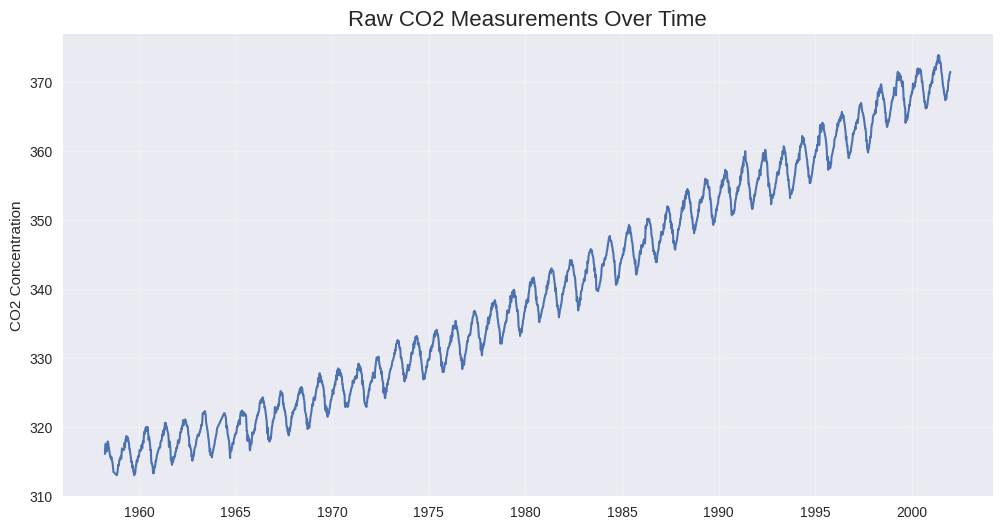

In [80]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["co2"], linewidth=1.5)
plt.title("Raw CO2 Measurements Over Time", fontsize=16)
plt.ylabel("CO2 Concentration")
plt.grid(True, alpha=0.3)
plt.show()


## Linear Trend Model

### Add a time index

In [81]:
df["Time"] = np.arange(len(df))
X = df[["Time"]]
y = df["co2"]

### Fit model

In [82]:
lin_model = LinearRegression()
lin_model.fit(X, y)
y_pred = pd.Series(lin_model.predict(X), index=df.index)

### Plot result

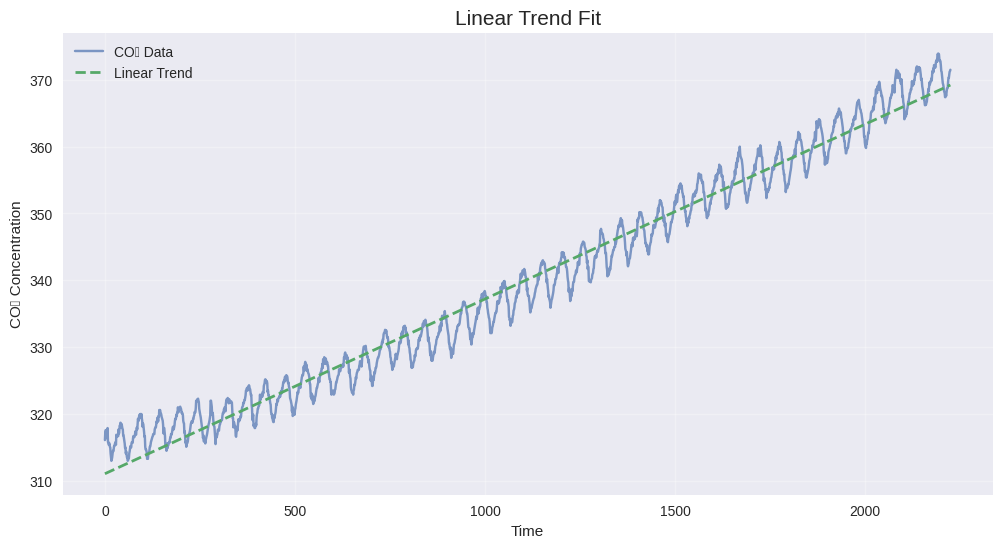

In [83]:
plt.figure(figsize=(12, 6))
plt.plot(df["Time"], y, label="CO₂ Data", alpha=0.7)
plt.plot(df["Time"], y_pred, "--", label="Linear Trend", linewidth=2)
plt.title("Linear Trend Fit", fontsize=15)
plt.xlabel("Time")
plt.ylabel("CO₂ Concentration")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Lag Feature Model

### Create lag-1 feature

In [84]:
df["Lag_1"] = df["co2"].shift(1)
df_lag = df.dropna(subset=["Lag_1"])

X = df_lag[["Lag_1"]]
y = df_lag["co2"]


### Train & predict

In [85]:
lag_model = LinearRegression()
lag_model.fit(X, y)
lag_pred = pd.Series(lag_model.predict(X), index=df_lag.index)

### Plot

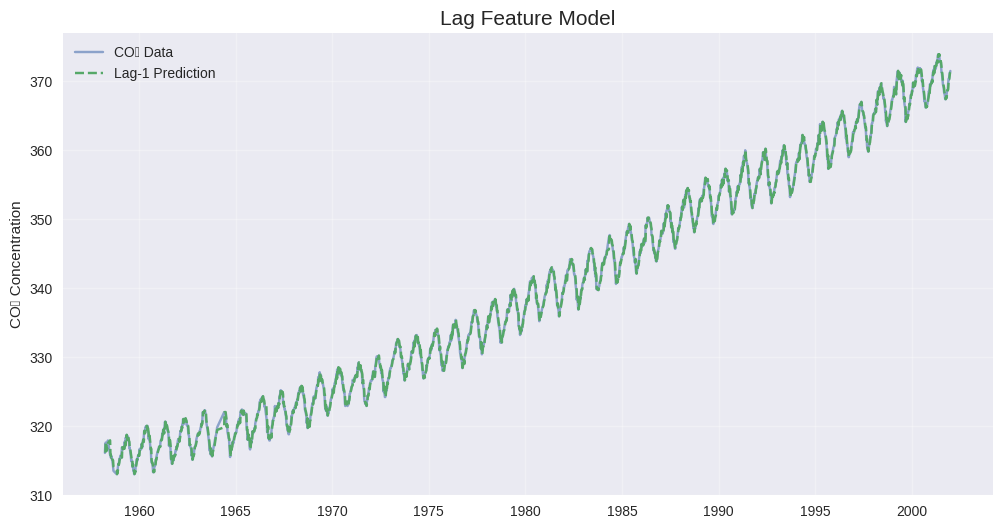

In [86]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["co2"], label="CO₂ Data", alpha=0.6)
plt.plot(lag_pred.index, lag_pred, "--", label="Lag-1 Prediction")
plt.title("Lag Feature Model", fontsize=15)
plt.ylabel("CO₂ Concentration")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Moving Average Trend

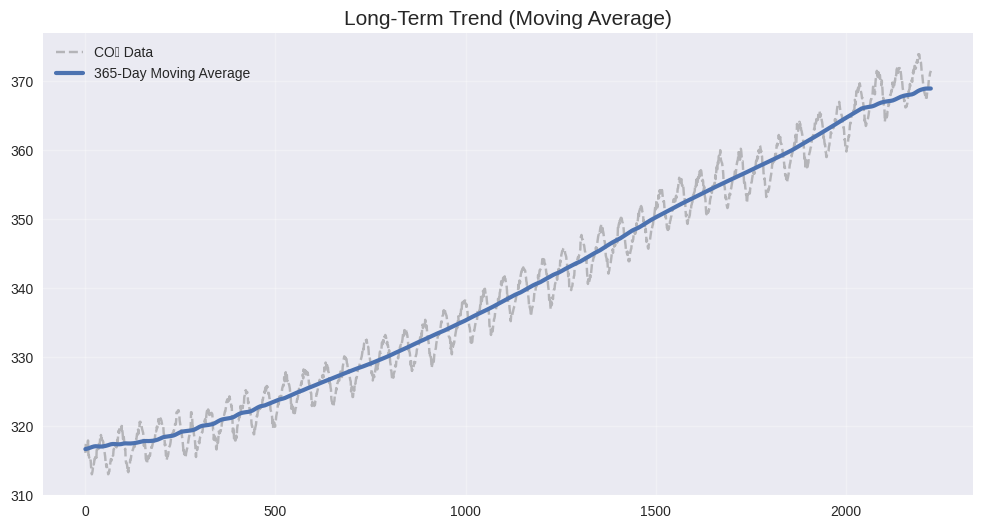

In [87]:
moving_avg = df["co2"].rolling(
    window=365, center=True, min_periods=100
).mean()

plt.figure(figsize=(12, 6))
plt.plot(df["Time"], df["co2"], "--", color="gray", alpha=0.5, label="CO₂ Data")
plt.plot(df["Time"], moving_avg, linewidth=3, label="365-Day Moving Average")
plt.title("Long-Term Trend (Moving Average)", fontsize=15)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Polynomial Trend with DeterministicProcess

### Build time matrix

In [88]:
dp = DeterministicProcess(
    index=df.index,
    constant=True,
    order=10,
    drop=True
)

X = dp.in_sample()
y = df["co2"]

trend_model = LinearRegression(fit_intercept=False)
trend_model.fit(X, y)

trend_pred = pd.Series(trend_model.predict(X), index=df.index)

### Plot

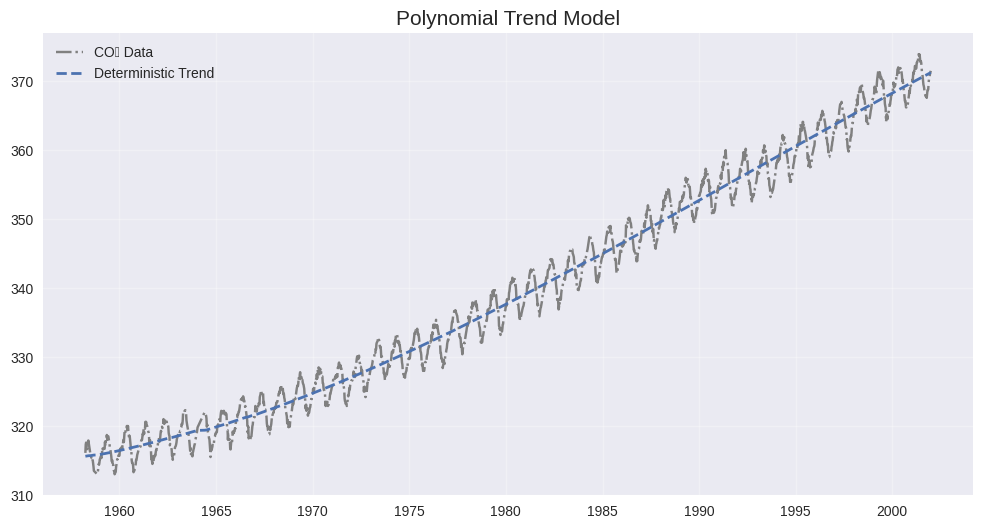

In [89]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["co2"], "-.", color="0.5", label="CO₂ Data")
plt.plot(df.index, trend_pred, "--", linewidth=2, label="Deterministic Trend")
plt.title("Polynomial Trend Model", fontsize=15)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Forecasting Future Values

### Generate Future design Matrix

In [90]:
X_fore = dp.out_of_sample(steps=50)
y_fore = pd.Series(trend_model.predict(X_fore), index=X_fore.index)
start = df["Time"].max() + 1
end   = start + len(y_fore)
y_fore.index = range(start, end)

In [91]:
print(f"X tail:{y_fore.tail()}")
print(f"df tail:{df.tail()}")

X tail:2270    372.534580
2271    372.562444
2272    372.590300
2273    372.618148
2274    372.645988
dtype: float64
df tail:              co2  Time  Lag_1
2001-12-01  370.3  2220  370.3
2001-12-08  370.8  2221  370.3
2001-12-15  371.2  2222  370.8
2001-12-22  371.3  2223  371.2
2001-12-29  371.5  2224  371.3


### Plot forecast

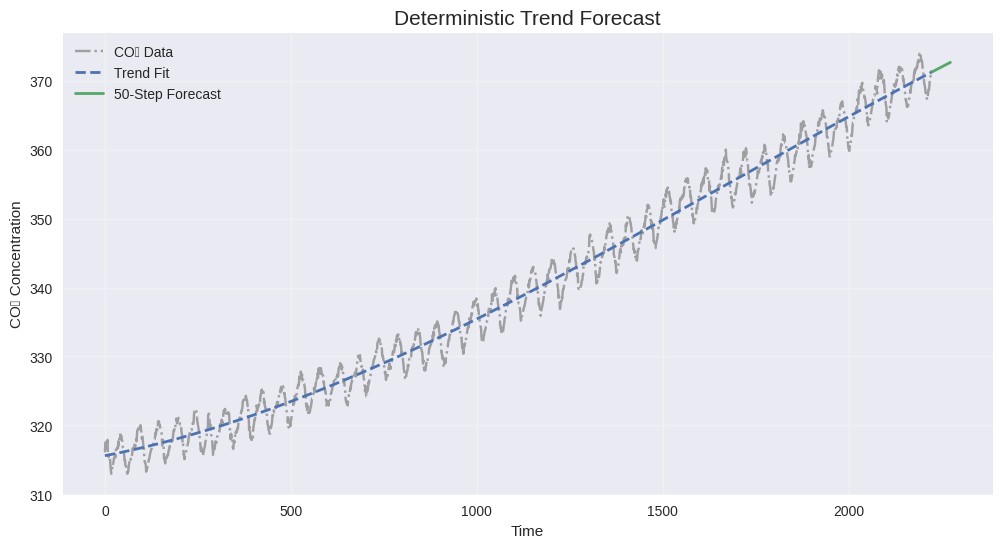

In [92]:
plt.figure(figsize=(12, 6))

plt.plot(df["Time"], df["co2"], "-.", color="gray", alpha=0.7, label="CO₂ Data")
plt.plot(df["Time"], trend_pred, "--", label="Trend Fit", linewidth=2)
plt.plot(y_fore.index, y_fore.values, "-", label="50-Step Forecast", linewidth=2)

plt.title("Deterministic Trend Forecast", fontsize=15)
plt.xlabel("Time")
plt.ylabel("CO₂ Concentration")
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()


## Seasonal Model (Fourier + Trend)

### Prepare Data

In [93]:
df.index = pd.to_datetime(df.index)
df = df.asfreq("W-SAT")
df["co2"] = df["co2"].interpolate()

### Build Fourier seasonal matrix

In [94]:
fourier = CalendarFourier(freq="W", order=10)

dp = DeterministicProcess(
    index=df.index,
    constant=True,
    order=4,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)

X = dp.in_sample()
y = df["co2"]

### Fit & forecast

In [95]:
season_model = LinearRegression(fit_intercept=False)
season_model.fit(X, y)

y_fit = pd.Series(season_model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(season_model.predict(X_fore), index=X_fore.index)

### Plot

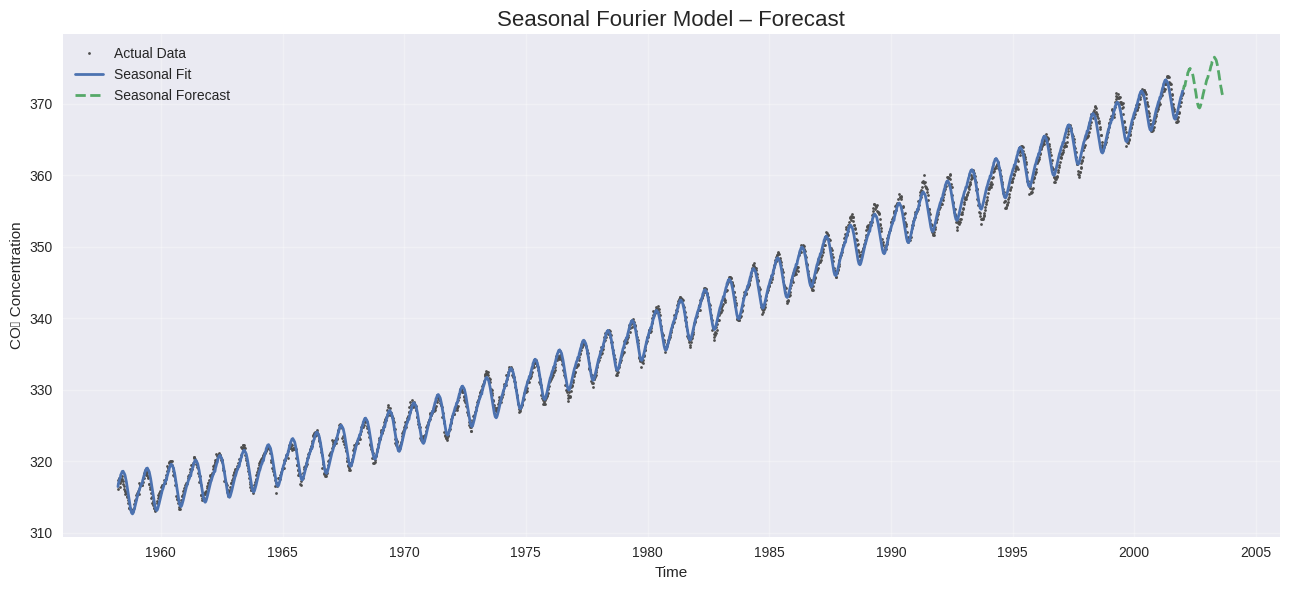

In [96]:
plt.figure(figsize=(13, 6))

plt.plot(y.index, y, ".", markersize=4, label="Actual Data", color="0.3")
plt.plot(y_fit.index, y_fit, linewidth=2, label="Seasonal Fit")
plt.plot(y_fore.index, y_fore, "--", linewidth=2, label="Seasonal Forecast")

plt.title("Seasonal Fourier Model – Forecast", fontsize=16)
plt.xlabel("Time")
plt.ylabel("CO₂ Concentration")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()